In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import helper
import time


# Load images and apply some random flips, rotations and normalization 

In [5]:
data_dir = 'Cat_Dog_data'


train_transforms = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                       transforms.CenterCrop(size=224),
                                       transforms.RandomRotation(degrees=15),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]) 

valid_transforms = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      transforms.CenterCrop(size=224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])




test_transforms = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      transforms.CenterCrop(size=224),
                                       transforms.ToTensor()]) 


train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=valid_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)


# Load a pre trained model Densenet121

In [4]:
model = models.densenet121(pretrained=True)
#model

# Building our own classifer 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0])


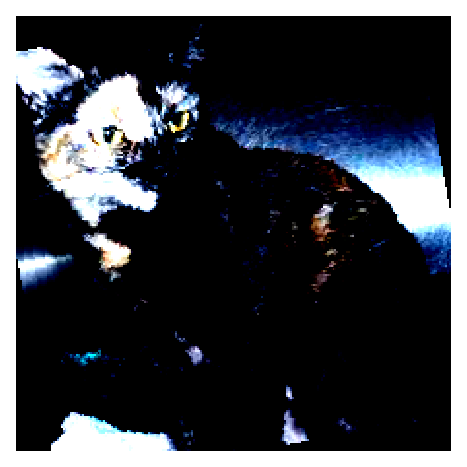

In [13]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

images, labels = next(iter(trainloader))
helper.imshow(images[0], normalize=False)
print(labels)

# Defining the loss function and the optimizer

In [25]:
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Run on GPU

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

# Validation function

In [26]:
def validation(model, validloader, criterion):
    
    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
 
        test_loss = 0
        accuracy = 0
        
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)

            output = model.forward(inputs)
            test_loss += criterion(output, labels).item()

            ps = torch.exp(output)
            equality = (labels.data == ps.max(dim=1)[1])
            accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy


# Training 

In [7]:
# TODO: Train a model with a pre-trained network
epochs = 3
print_every = 10
steps = 0

start = time.time()

for e in range(epochs):
    
    # Set to training mode
    model.train()
    
    # Set loss and accuracy 
    t_loss = 0
    t_accuracy = 0
    v_loss = 0
    v_accuracy = 0
    
    for inputs, labels in trainloader:
        
        steps += 1
        
        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Clean existing gradients
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model.forward(inputs)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        t_loss += loss.item()
        
        ps = torch.exp(output)
        
        equality = (labels.data == ps.max(dim=1)[1])
        #print(ps.max(dim=1))
        #print(labels)
        t_accuracy += equality.type(torch.FloatTensor).mean()
        
        if steps % print_every == 0:
            
            v_loss, v_accuracy = validation(model, validloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(t_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(v_loss/len(validloader)),
                  "Train Accuracy: {:.3f}".format(t_accuracy/len(trainloader)),
                  "Test Accuracy: {:.3f} ".format(v_accuracy/len(validloader)))
            
            t_loss = 0
            t_accuracy = 0
            # Make sure training is back on
            model.train()
print('Done Traing with accurary:{:.3f}'.format(v_accuracy/len(validloader)))

NameError: name 'optimizer' is not defined


# Load the trained Classifier 

In [3]:
model=torch.load('classifier.pt', map_location=lambda storage, loc: storage)


# Run to random pick a pic and predict its class

Dog:  99.99856948852539 %..... Cat:  0.001430511474609375 %


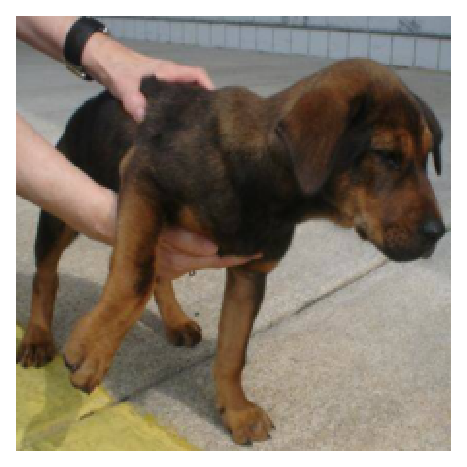

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

inputs, labels = next(iter(testloader))
images, labels = inputs.to(device), labels.to(device)
helper.imshow(inputs[0], normalize=False)

#print(inputss.size())

with torch.no_grad():
    # do forward pass on images and get the output
    output = model.forward(images)
    
# exp the output because output is log softmax    
ps = torch.exp(output)

# prediected labels (0=cat , 1=dog) for all 64 images / index of the highest prob.
out_labels=ps.max(dim=1)[1]

# the highest probabilities of all cat and dog for 64 images
prob_out = ps.max(dim=1)[0]

# the probability of the given image 
img_prob = prob_out.data.cpu().numpy()[0]

#if output label of the given image
if out_labels[0] == 1:
  print('Dog: ',img_prob*100,'%.....',
        'Cat: ',100-img_prob*100, '%')

else: print('Cat :' ,img_prob*100,'%.....',
            'Dog: ',100-img_prob*100, '%')
 